In [ ]:
import re
import pandas as pd
import numpy as np

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns




#!pip install xlrd
url="https://www.sharkattackfile.net/spreadsheets/GSAF5.xls"
shark_df = pd.read_excel(url)
shark_df_copy = shark_df.copy()

columns_to_drop = shark_df_copy.columns[15:23]
shark_df_copy = shark_df_copy.drop(columns=columns_to_drop, axis=1)

# Marc's code start
shark_df_copy.isna().sum() #50 null values in column country and 482 null values in state column

shark_df_copy.dropna(subset=["Country", "State"]) #dropping all rows where there are null values in Country or State columns

primary_countries = shark_df_copy["Country"].value_counts() #show the primary countries where shark attacks occur

#print(primary_countries)

shark_df_copy["Country"] = shark_df_copy['Country'].astype(str).str.lower().str.strip() #convert all to lowercase and remove whitespace for consistency
shark_df_copy['State'] = shark_df_copy['State'].astype(str).str.lower().str.strip()        #in the data. Also changing all data in the columns to strings
#Marc 's code end

#Clara's code start
#creating a priority map allows us to change the initial values to "categories" and make the data more understandable. in this map order matters and we use it to our advantage.
def clean_activity(shark_df_copy): #def clean_age(shark_df_copy):
  priority_map = [
      (['disaster', 'adrift', 'sunk', 'sink', 'wreck', 'founde', 'sank', 'capsiz', 'overboard'], 'Disaster'), #this is the first priority because we do not want to overwrite "overboard" as "Surfing/ Boarding"
      (['surf', 'board', 'sruf', 'paddl', 'sup'], 'Surfing/ Boarding'),
      (['swim', 'float', 'swm'], 'Swimming/ Floating'),
      (['fish', 'lobster', 'scallop', 'shrimp', 'crab', 'oyster', 'hunt', 'harpoon', 'fihi'], 'Fishing'),
      (['boat', 'kayak', 'ship', 'raft', 'canoe', 'row', 'sail', 'yacht', 'jet ski'], 'Boating/ Watercraft'),
      (['wad'], 'Wading'),
      (['bath'], 'Bathing'),
      (['diving', 'dive'], 'Diving'),
      (['snork'], 'Snorkeling'),
      (['stand', 'sit', 'squat'], 'Standing/ Sitting'),
      (['shark'], 'Handling/ Looking at Shark'),
      (['play'], 'Playing')
  ]

#
  def categorize_activity_priority(activity):
      if pd.isna(activity): #for missing values
          return "Unknown"
      for keywords, category in priority_map:
          if any(keyword in activity.lower() for keyword in keywords):
              return category
      return "Other"

#looking at the different categories and how many values of each there are to compare with the uncleaned version
  shark_df_copy['Activity'] = shark_df_copy['Activity'].apply(categorize_activity_priority)
  #print(shark_df_copy['Activity'].value_counts())
  return shark_df_copy

clean_activity(shark_df_copy) #clean_age (shark_df_copy)

#clara - unnamed column about if the attack was fatal
def clean_fatal(shark_df_copy):
  shark_df_copy.rename(columns={shark_df_copy.columns[11]: 'was_it_fatal'}, inplace=True)
  shark_df_copy['was_it_fatal'] = shark_df_copy['was_it_fatal'].str.lower().str.strip()
  fatality_map = {
    'y': 'Yes',
    'f': 'Yes',
    'y x 2': 'Yes',
    'n': 'No',
    'm': 'No',
    'nq': 'No',
    'unknown': 'Unknown',
    '2017': 'Unknown'
  }

  shark_df_copy['was_it_fatal'] = shark_df_copy['was_it_fatal'].map(fatality_map).fillna('Unknown')
  display(shark_df_copy['was_it_fatal'].value_counts())
clean_fatal(shark_df_copy)

#Clara's code end


#Aurélie's code start
#date to season start 
#date format 
shark_df_copy['Date'] = pd.to_datetime(shark_df_copy['Date'], errors='coerce').dt.date
shark_df_copy.dropna(subset=['Date'], inplace=True)
shark_df_copy.drop_duplicates(subset=['Date'], inplace=True)
shark_df_copy.sort_values(by='Date', inplace=True)

# function to diff hemisphere north and south + convert to season

def determine_hemisphere(country):
    southern_hemisphere = ['AUSTRALIA', 'BRAZIL', 'SOUTH AFRICA', 'ARGENTINA']  # to determine later
    return 'south' if country in southern_hemisphere else 'north'
#create a hemisphere column just for test purpose 
shark_df_copy['Hemisphere'] = shark_df_copy['Country'].apply(determine_hemisphere)

def get_season(date, hemisphere):
    month = date.month
    if hemisphere == 'north':
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    else:  # South
        if month in [12, 1, 2]:
            return 'Summer'
        elif month in [3, 4, 5]:
            return 'Fall'
        elif month in [6, 7, 8]:
            return 'Winter'
        else:
            return 'Spring'
#create a column season for test purpose
shark_df_copy['Season'] = shark_df_copy.apply(lambda row: get_season(row['Date'], row['Hemisphere']), axis=1)


#end of date format by season

#function for times values and part of the day

def clean_time(time_str):
    if pd.isna(time_str):
        return None #fill with mean() than midnight
    # Remove non-numeric and non-h characters
    time_str = re.sub(r'[^0-9h]', '', time_str)
    
    # If the time format is hMM or hhMM
    match = re.match(r'(\d{1,2})h(\d{2})$', time_str)
    if match:
        return f"{match.group(1).zfill(2)}:{match.group(2)}"
    
    # If the time format is hhh or hhMM
    match = re.match(r'(\d{1,3})h$', time_str)
    if match:
        return pd.to_datetime(match.group(1).zfill(4), format='%H%M', errors='coerce').strftime('%H:%M')
    
    # Default case to handle any other remaining formats
    match = re.match(r'(\d{1,2})h(\d{2})?$', time_str)
    if match:
        hour = match.group(1).zfill(2)
        minute = match.group(2) if match.group(2) else '00'
        return f"{hour}:{minute}"
    return None #fill with mean() than midnight



def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

#End of function for times values


#security, update of column time + creation of the column Time_of_Day

# Ensure 'Time' column is properly formatted as string
shark_df_copy['Time'] = shark_df_copy['Time'].astype(str)
shark_df_copy['Time'] = shark_df_copy['Time'].apply(clean_time)

valid_times = pd.to_datetime(shark_df_copy['Time'], format='%H:%M', errors='coerce')

mean_time = valid_times.dropna().mean()
mean_time_str = mean_time.strftime('%H:%M')
shark_df_copy['Time'] = shark_df_copy['Time'].fillna(mean_time_str)

shark_df_copy['Time'] = pd.to_datetime(shark_df_copy['Time'], format='%H:%M', errors='coerce').dt.time

shark_df_copy['Time_of_Day'] = shark_df_copy['Time'].apply(lambda x: time_of_day(x.hour) if pd.notnull(x) else 'Invalid Time')

#Aurélie's code end





#Alvaro's code start
frequency = shark_df_copy["Age"].value_counts()
values_to_keep = frequency[frequency > 1].index
shark_df_copy = shark_df_copy[shark_df_copy['Age'].isin(values_to_keep)]

#mapping age values
age_mapping = {"young": "21", "Teen": "12", "?": "N/A", "50s": "50", "60s": "60", "40s": "40", "20s": "20","30s": "30","8 or 10": "9","7 or 8": "8","teen": "12"," ": "N/A","Unkown ": "N/A"}
shark_df_copy['Age'] = shark_df_copy['Age'].replace(age_mapping)

#delete "N/A" values
shark_df_copy['Age'] = shark_df_copy['Age'].replace("N/A", np.nan)
shark_df_copy = shark_df_copy.dropna(subset=['Age'])

#convert into int
shark_df_copy['Age'] = shark_df_copy['Age'].astype(int)

#categorize ages
bins = [0, 11, 21, 30, 45, 64, float('inf')]
labels = ['Children', 'Teenagers', 'Young Adults', 'Middle-aged Adults', 'Older Adults', 'Seniors']
shark_df_copy['AgeCategory'] = pd.cut(shark_df_copy['Age'], bins=bins, labels=labels, right=True)

#print % of attacks by age category
freq = shark_df_copy["AgeCategory"].value_counts()
percentage = freq / freq.sum() * 100
summary_shark_df = pd.DataFrame({'Frequency': freq, 'Percentage': percentage})
#print(summary_shark_df)

#Species
#rename column name
shark_df_copy = shark_df_copy.rename(columns={'Species ': 'Species'})
#shark_df_copy["Species"].unique()

#Species
#check for top species attacks
top_10_species = shark_df_copy['Species'].value_counts().head(10)
#print(top_10_species)

#Species
#check for frequency 1 values
species_counts = shark_df_copy['Species'].value_counts()
frequency_of_one_count = (species_counts == 1).sum()
#print(frequency_of_one_count)

#Species
#check for nan values
nan_count_species = shark_df_copy['Species'].isna().sum()
#print(nan_count_species)

#Sex
#delete spaces, change "M x 2", "lli", "." and "N" to "M"

shark_df_copy["Sex"] = shark_df_copy["Sex"].str.strip()
shark_df_copy["Sex"] = shark_df_copy["Sex"].replace("M x 2", "M")
shark_df_copy["Sex"] = shark_df_copy["Sex"].replace("N", "M")
shark_df_copy["Sex"] = shark_df_copy["Sex"].replace("lli", "M")
shark_df_copy["Sex"] = shark_df_copy["Sex"].replace(".", "M")

value_counts = shark_df_copy['Sex'].value_counts(dropna=False)
#print(value_counts)

#pivot table for attacks per agecategory and sex
shark_df_copy.groupby('AgeCategory', observed=False)['Sex'].value_counts(dropna=False)
pivot_table = shark_df_copy.pivot_table(index='AgeCategory', columns='Sex', aggfunc='size', fill_value=0, observed=False)
#print(pivot_table)

#Alvaro's code end 
#create an excel copy just for test purpose
shark_df_copy.to_excel('cleaned_GSAF5.xlsx', index=False)
shark_df_copy.info()
# now we have a decent date column need to convert date to season depending of country southern hemisphere vs north  


was_it_fatal
No         4871
Yes        1468
Unknown     634
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 6823 to 0
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Date          3141 non-null   object  
 1   Year          3141 non-null   float64 
 2   Type          3134 non-null   object  
 3   Country       3141 non-null   object  
 4   State         3141 non-null   object  
 5   Location      3030 non-null   object  
 6   Activity      3141 non-null   object  
 7   Name          3133 non-null   object  
 8   Sex           3114 non-null   object  
 9   Age           3141 non-null   int32   
 10  Injury        3134 non-null   object  
 11  was_it_fatal  3141 non-null   object  
 12  Time          3141 non-null   object  
 13  Species       1988 non-null   object  
 14  Source        3134 non-null   object  
 15  Hemisphere    3141 non-null   object  
 16  Season        3141 non-null   object  
 17  Time_of_Day   3141 non-null   object  
 18  AgeCategory  

C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\4017421123.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_counts.index, y=activity_counts.values , palette='hls')


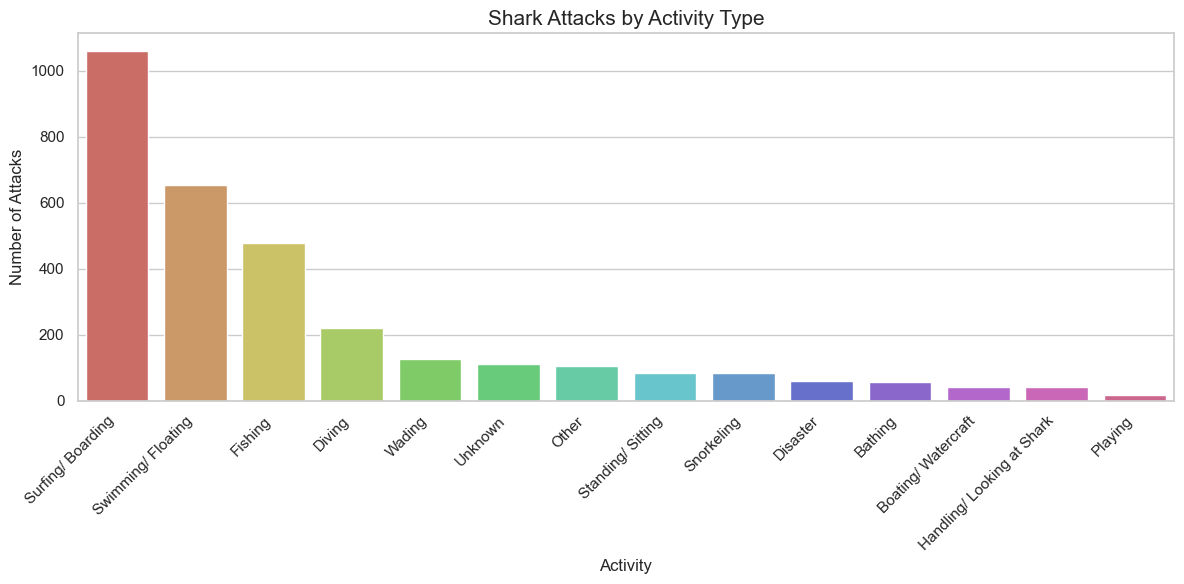

In [44]:
#shark attack activity

plt.figure(figsize=(12, 6))
activity_counts = shark_df_copy['Activity'].value_counts()
sns.barplot(x=activity_counts.index, y=activity_counts.values , palette='hls')
plt.title('Shark Attacks by Activity Type', fontsize=15)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

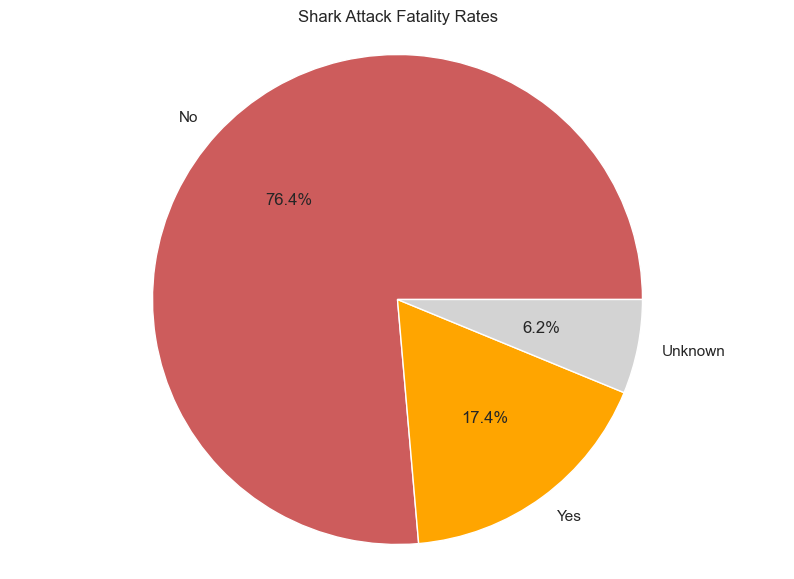

In [55]:
# fatal shark attack pie

plt.figure(figsize=(10, 7))
fatal_counts = shark_df_copy['was_it_fatal'].value_counts()
plt.pie(fatal_counts, labels=fatal_counts.index, autopct='%1.1f%%', 
        colors=['indianred', 'orange', 'lightgray'])
plt.title('Shark Attack Fatality Rates', fontsize=12)
plt.axis('equal')
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\605674921.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_counts.index, y=time_counts.values,


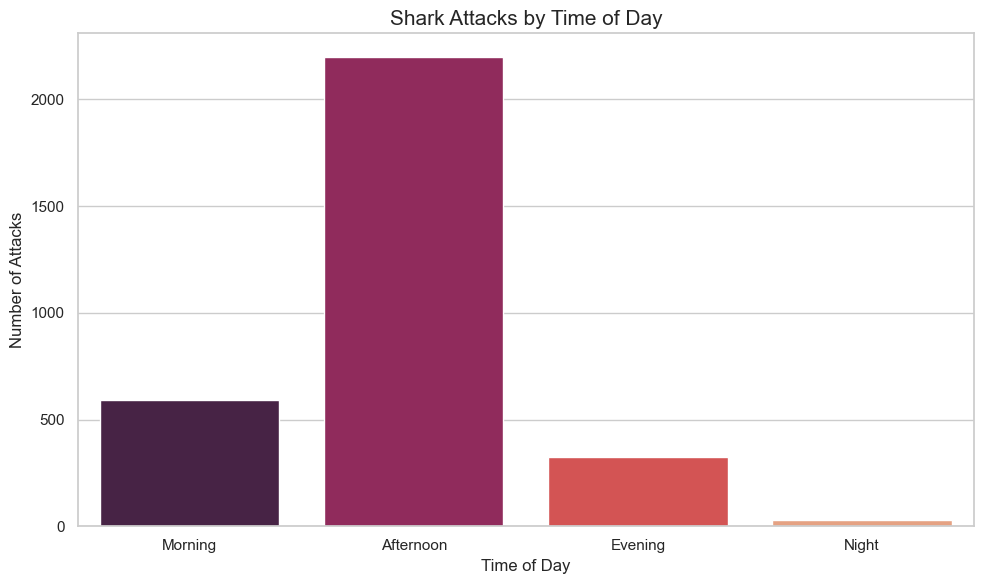

In [53]:
#shark attack by time of the day 

plt.figure(figsize=(10, 6))
time_counts = shark_df_copy['Time_of_Day'].value_counts()
sns.barplot(x=time_counts.index, y=time_counts.values, 
            order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='rocket')
plt.title('Shark Attacks by Time of Day', fontsize=15)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\2083102229.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, palette='rocket')


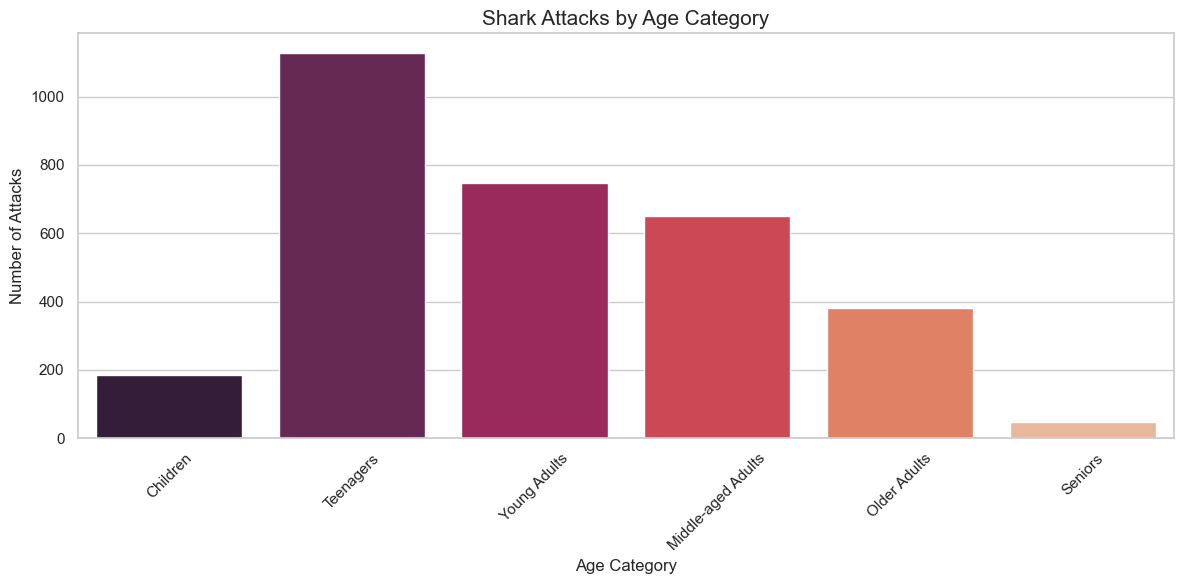

In [51]:
#shark attack by age category

plt.figure(figsize=(12, 6))
age_counts = shark_df_copy['AgeCategory'].value_counts()
sns.barplot(x=age_counts.index, y=age_counts.values, palette='rocket')
plt.title('Shark Attacks by Age Category', fontsize=15)
plt.xlabel('Age Category', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\4010967138.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_counts.index, y=time_counts.values,


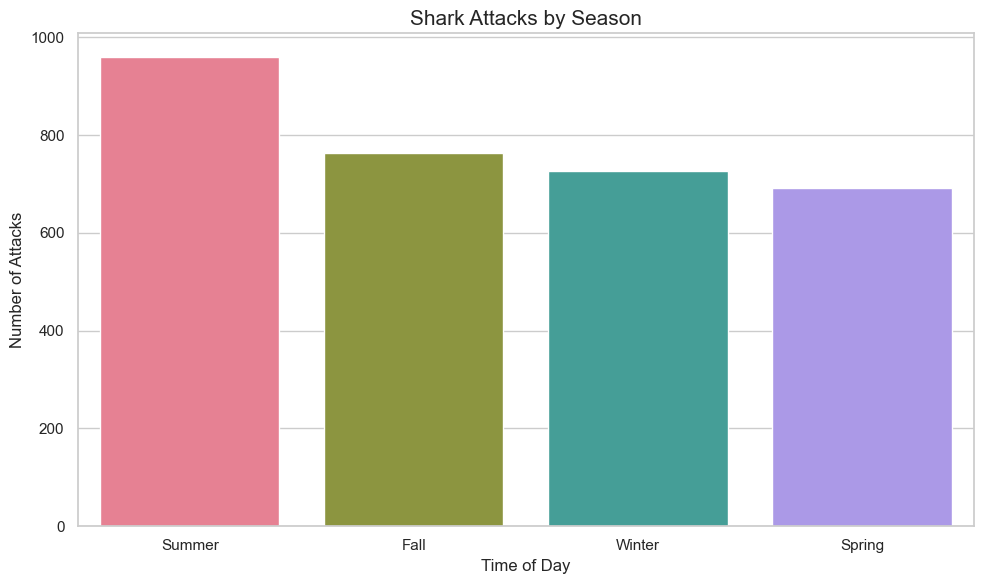

In [ ]:
#shark attack by season

plt.figure(figsize=(10, 6))
time_counts = shark_df_copy['Season'].value_counts()
sns.barplot(x=time_counts.index, y=time_counts.values, 
            order=['Summer', 'Fall', 'Winter', 'Spring'], palette='husl')
plt.title('Shark Attacks by Season', fontsize=15)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\1281487385.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=countries_counts.index, y=countries_counts.values, palette='husl')


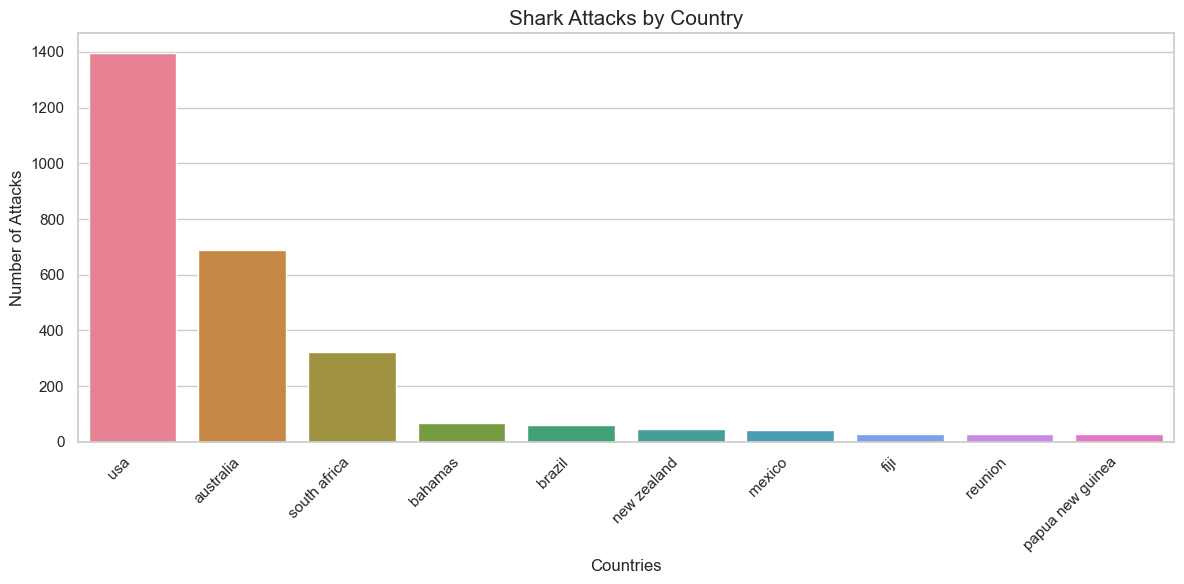

In [46]:
#shark attacks by country

countries_counts = shark_df_copy['Country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=countries_counts.index, y=countries_counts.values, palette='husl')
plt.title('Shark Attacks by Country', fontsize=15)
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


C:\Users\aurel\AppData\Local\Temp\ipykernel_26972\1201571055.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='husl')


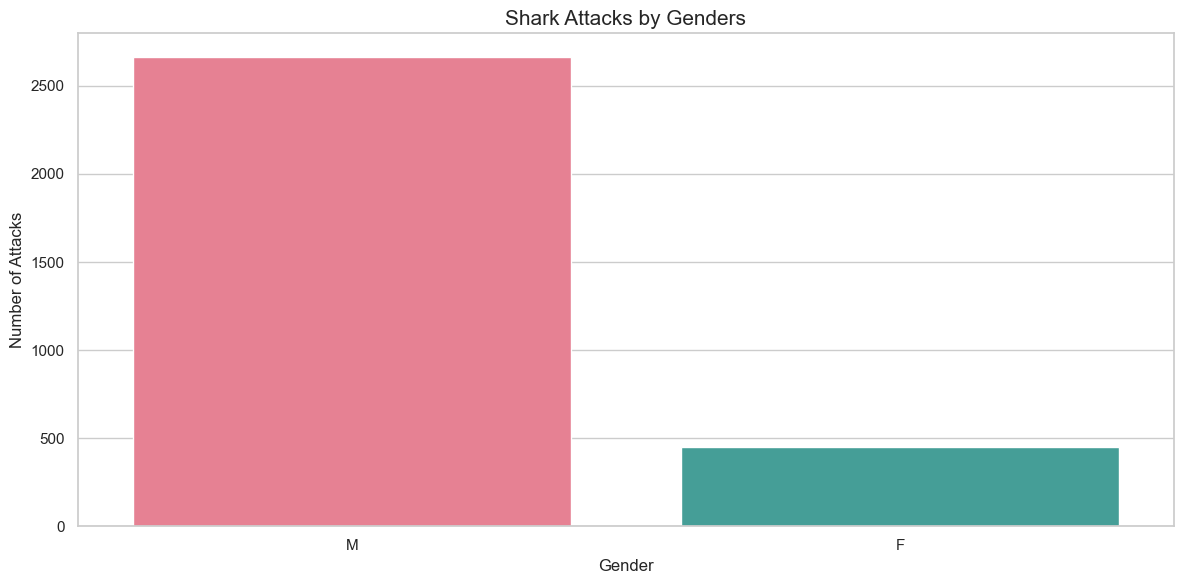

In [52]:
#shark attack by sex Sex

gender_counts = shark_df_copy['Sex'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='husl')
plt.title('Shark Attacks by Genders', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
#plt.xticks(rotation=45, ha='right')
plt.tight_layout()